In [3]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

pd.set_option('display.max_rows',70)
display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

In [4]:
inputFile = 'collected-data.csv'

In [5]:
df = pd.read_csv(inputFile)
df

,timestamp,sensor_type,sensor_name,value,accuracy
0,1620723880333,-1,INDOOR,1.0,NaN
1,1620723880364,-1,MONITORING,1.0,NaN
2,1620723873432,5,TMD3725_Light Ambient Light Sensor Non-wakeup,15.0,3.0
3,1620723873265,8,TMD3725_Proximity Proximity Sensor Wakeup,5.0,3.0
4,1620723882262,-1,GPS_SATELLITES,17.0,NaN
...,...,...,...,...,...
2403,1620733476294,5,TMD3725_Light Ambient Light Sensor Non-wakeup,8.0,3.0
2404,1620733477129,8,TMD3725_Proximity Proximity Sensor Wakeup,5.0,3.0
2405,1620733477434,5,TMD3725_Light Ambient Light Sensor Non-wakeup,2.0,3.0
2406,1620733480731,5,TMD3725_Light Ambient Light Sensor Non-wakeup,2.0,3.0


In [6]:
sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}

for index,row in df.iterrows():
    if  df.loc[index,'sensor_type'] == -1:
        df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]

In [26]:
df_wide = df.pivot_table(index=['timestamp'], columns='sensor_name', values='value')


last_seen_values = {}
sensor_types = df['sensor_name'].unique()
for sensor_type in sensor_types:
    last_seen_values[sensor_type] = float('nan')

for index,row in df_wide.iterrows():
    if row['MONITORING'] == 0:
        for sensor_type in sensor_types:
            last_seen_values[sensor_type] = float('nan')
    else:        
        for sensor_type in sensor_types:
            if math.isnan(row[sensor_type]):
                row[sensor_type] = last_seen_values[sensor_type]
            last_seen_values[sensor_type] = row[sensor_type] 

for index,row in df_wide.iterrows():
    containsNaN = 0.0
    for sensor_type in sensor_types:
        if math.isnan(row[sensor_type]):
            containsNaN = 1.0
            break
    df_wide.loc[index,'containsNaN'] = containsNaN

df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0)] 
del df_wide['containsNaN']

proximity_name = ""
light_name = ""
for sensor_type in sensor_types:
    if 'proximity' in sensor_type.lower():
        proximity_name = sensor_type
        break
    if 'light' in sensor_type.lower():
        light_name = sensor_type
        
df_wide.loc[(df_wide[proximity_name] != 0.0),proximity_name] = 1



df_wide.sort_values(['timestamp'], inplace=True)
target = df_wide.loc[:,'INDOOR']
del df_wide['INDOOR']

del df_wide['GPS_FIX']

df_wide.to_csv('preprocessed_data.csv')
target.to_numpy()
df_wide

sensor_name,BLUETOOTH_DEVICES,DETECTED_ACTIVITY,GPS_FIX_SATELLITES,GPS_SATELLITES,MONITORING,TMD3725_Light Ambient Light Sensor Non-wakeup,TMD3725_Proximity Proximity Sensor Wakeup,WIFI_ACCESS_POINTS
timestamp,,,,,,,,
1620724298381,1.0,3.0,0.0,35.0,1.0,7.0,0.0,8.0
1620724299464,1.0,3.0,0.0,35.0,1.0,7.0,0.0,8.0
1620724300115,1.0,3.0,0.0,35.0,1.0,7.0,1.0,8.0
1620724300588,1.0,3.0,0.0,35.0,1.0,7.0,1.0,9.0
1620724300600,2.0,3.0,0.0,35.0,1.0,7.0,1.0,9.0
...,...,...,...,...,...,...,...,...
1620733475300,0.0,3.0,0.0,39.0,1.0,2.0,0.0,2.0
1620733476294,0.0,3.0,0.0,39.0,1.0,8.0,0.0,2.0
1620733477129,0.0,3.0,0.0,39.0,1.0,8.0,1.0,2.0


In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_wide.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(1551, 8) (765, 8) (1551,) (765,)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
D = X_train.shape[1]

In [39]:
# Now all the fun Tensorflow stuff
# Build the model

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Alternatively, you can do:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(1, input_shape=(D,), activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)


# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/200
49/49 [==============================] - 1s 10ms/step - loss: 0.7432 - accuracy: 0.5712 - val_loss: 0.6441 - val_accuracy: 0.5908
Epoch 2/200
49/49 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6074 - val_loss: 0.5776 - val_accuracy: 0.6588
Epoch 3/200
49/49 [==============================] - 0s 4ms/step - loss: 0.5606 - accuracy: 0.7279 - val_loss: 0.5304 - val_accuracy: 0.7922
Epoch 4/200
49/49 [==============================] - 0s 4ms/step - loss: 0.5142 - accuracy: 0.8079 - val_loss: 0.4856 - val_accuracy: 0.8405
Epoch 5/200
49/49 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.8291 - val_loss: 0.4441 - val_accuracy: 0.8601
Epoch 6/200
49/49 [==============================] - 0s 3ms/step - loss: 0.4311 - accuracy: 0.8594 - val_loss: 0.4072 - val_accuracy: 0.8719
Epoch 7/200
49/49 [==============================] - 0s 3ms/step - loss: 0.3967 - accuracy: 0.8588 - val_loss: 0.3755 - val_accuracy: 0.8549
Epoch 8/200


49/49 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.9729 - val_loss: 0.1129 - val_accuracy: 0.9725
Epoch 58/200
49/49 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9736 - val_loss: 0.1106 - val_accuracy: 0.9725
Epoch 59/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.9774 - val_loss: 0.1083 - val_accuracy: 0.9739
Epoch 60/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.9749 - val_loss: 0.1060 - val_accuracy: 0.9739
Epoch 61/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1206 - accuracy: 0.9774 - val_loss: 0.1038 - val_accuracy: 0.9791
Epoch 62/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9768 - val_loss: 0.1016 - val_accuracy: 0.9791
Epoch 63/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1165 - accuracy: 0.9774 - val_loss: 0.0993 - val_accuracy: 0.9791
Epoch 64/200
49/49 

Epoch 115/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0408 - val_accuracy: 0.9882
Epoch 116/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0494 - accuracy: 0.9858 - val_loss: 0.0403 - val_accuracy: 0.9882
Epoch 117/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.9858 - val_loss: 0.0397 - val_accuracy: 0.9882
Epoch 118/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9858 - val_loss: 0.0389 - val_accuracy: 0.9882
Epoch 119/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9858 - val_loss: 0.0387 - val_accuracy: 0.9882
Epoch 120/200
49/49 [==============================] - 0s 4ms/step - loss: 0.0463 - accuracy: 0.9858 - val_loss: 0.0383 - val_accuracy: 0.9882
Epoch 121/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9858 - val_loss: 0.0379 - val_accuracy: 0.9882

Epoch 172/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9865 - val_loss: 0.0238 - val_accuracy: 0.9882
Epoch 173/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9884 - val_loss: 0.0245 - val_accuracy: 0.9882
Epoch 174/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9890 - val_loss: 0.0245 - val_accuracy: 0.9882
Epoch 175/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9890 - val_loss: 0.0240 - val_accuracy: 0.9882
Epoch 176/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9890 - val_loss: 0.0238 - val_accuracy: 0.9882
Epoch 177/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9890 - val_loss: 0.0237 - val_accuracy: 0.9882
Epoch 178/200
49/49 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9890 - val_loss: 0.0240 - val_accuracy: 0.9882

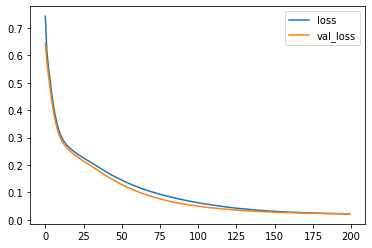

In [40]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

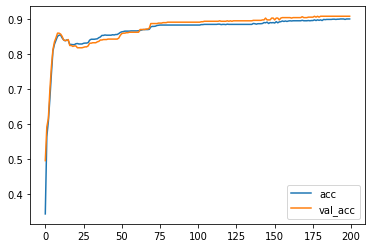

In [36]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
